# Comparing M6A ML models (HIFI read models)

In [2]:
# Get all the requisite imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import pandas as pd
import requests
import io
import xgboost as xgb 
from m6a_calling import M6ANet

from sklearn.metrics import (confusion_matrix,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             balanced_accuracy_score,
                             matthews_corrcoef,
                             roc_auc_score,
                             average_precision_score,
                             roc_curve,
                             precision_recall_curve
                             )

### Read in the HiFi test data

In [3]:
# HiFi data

data_path = "../data/m6A_test_other_half_hifi.npz"

train_val_data = np.load(data_path, allow_pickle=True)

# Get the dictionary from the containing relevant data
train_val_data = train_val_data['save_data_dict'][()]

# Load test features and labels
X_test = train_val_data['X_test']
y_test = train_val_data['y_test']

### Predict using the CNN model

In [4]:
m6a_model = torch.load("models/m6ANet_other_half_hifi.3.best.torch", map_location=torch.device('cpu'))

X_test = torch.Tensor(X_test)
test_pred_cnn = m6a_model.predict(X_test, device='cpu').detach().numpy()

### Predict using the XGBoost model

In [10]:
bst2 = xgb.Booster({'nthread': 4})  # init model
bst2.load_model('models/xgboost.otherhalf.hifi.100rds.json')  # load data

X_test_2d = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

dtest = xgb.DMatrix(X_test_2d)
test_pred_xgb = bst2.predict(dtest)

### Plot ROC curve for XGBoost and CNN models

AUC-ROC CNN: 0.995
AUC-ROC XGBoost: 0.995


[]

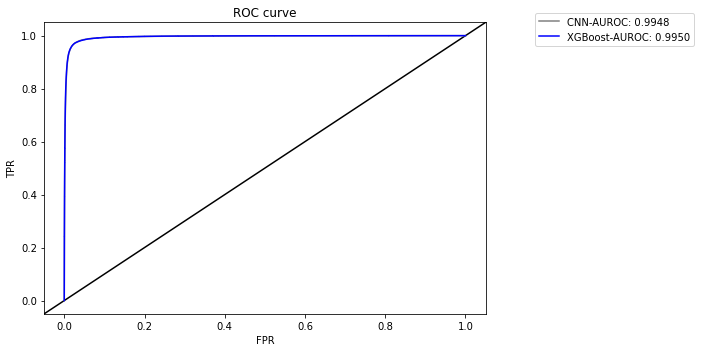

In [11]:
plt.figure(figsize=(10,5))
plt.axline([0,0], slope=1, c="black")

fpr, tpr, thresholds = metrics.roc_curve(y_test[:, 0], test_pred_cnn[:, 0], pos_label=1)
print(f"AUC-ROC CNN: {metrics.auc(fpr, tpr):.03f}")
plt.plot(fpr, tpr, c='gray', label=f"CNN-AUROC: {metrics.auc(fpr, tpr):.04f}")

fpr, tpr, thresholds = metrics.roc_curve(y_test[:, 0], test_pred_xgb, pos_label=1)
print(f"AUC-ROC XGBoost: {metrics.auc(fpr, tpr):.03f}")
plt.plot(fpr, tpr, c='blue', label=f"XGBoost-AUROC: {metrics.auc(fpr, tpr):.04f}")


plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
#plt.xlim([-0.1, 1.1])
#plt.ylim([0, 1.1])
plt.tight_layout()
plt.savefig("figures/roc_compare_hifi.png")
plt.plot()


### Focus on 1% FPR with the ROC curve

AUC-ROC CNN: 0.9948
AUC-ROC XGBoost: 0.9950


[]

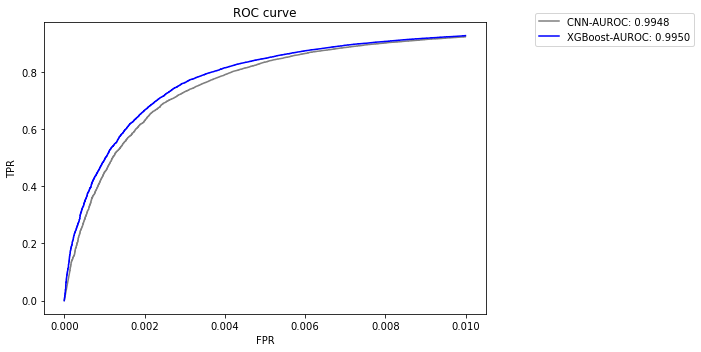

In [15]:
plt.figure(figsize=(10,5))
#plt.axline([0,0], slope=1, c="black")

fpr, tpr, thresholds = metrics.roc_curve(y_test[:, 0], test_pred_cnn[:, 0], pos_label=1)

idx_fpr = np.where(fpr <= 0.010)[0]

thr_last = thresholds[idx_fpr][-1]

print(f"AUC-ROC CNN: {metrics.auc(fpr, tpr):.04f}")
plt.plot(fpr[idx_fpr], tpr[idx_fpr], c='gray', label=f"CNN-AUROC: {metrics.auc(fpr, tpr):.04f}")

fpr, tpr, thresholds = metrics.roc_curve(y_test[:, 0], test_pred_xgb, pos_label=1)
idx_fpr = np.where(fpr <= 0.010)[0]

thr_last = thresholds[idx_fpr][-1]

print(f"AUC-ROC XGBoost: {metrics.auc(fpr, tpr):.04f}")
plt.plot(fpr[idx_fpr], tpr[idx_fpr], c='blue', label=f"XGBoost-AUROC: {metrics.auc(fpr, tpr):.04f}")


plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
#plt.xlim([-0.1, 1.1])
#plt.ylim([0, 1.1])
plt.tight_layout()
plt.savefig("figures/roc_compare_hifi_fdr_1.png")
plt.plot()


### Plot the PR curve using XGBoost and CNN predictions on HiFi data

AU-PR CNN: 0.9470324050832672
AU-PR XGBoost: 0.9522379397524735


[]

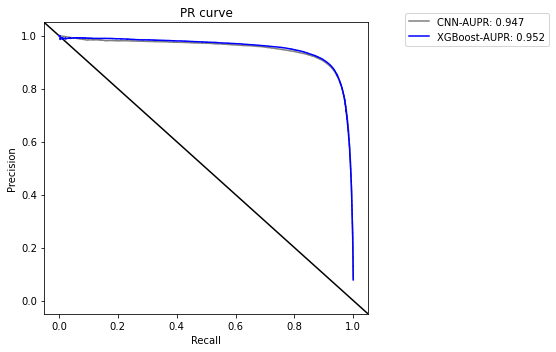

In [13]:
plt.figure(figsize=(8,5))
plt.axline([0,0], slope=1, c="white")
plt.axline([0,1], slope=-1, c="black")
precision, recall, thresholds = metrics.precision_recall_curve(y_test[:, 0], test_pred_cnn[:, 0], pos_label=1)
print(f"AU-PR CNN: {metrics.average_precision_score(y_test[:, 0], test_pred_cnn[:, 0])}")
plt.plot(recall, precision, c='gray', label=f"CNN-AUPR: {metrics.average_precision_score(y_test[:, 0], test_pred_cnn[:, 0]):.03f}")

precision, recall, thresholds = metrics.precision_recall_curve(y_test[:, 0], test_pred_xgb, pos_label=1)
print(f"AU-PR XGBoost: {metrics.average_precision_score(y_test[:, 0], test_pred_xgb)}")
plt.plot(recall, precision, c='blue', label=f"XGBoost-AUPR: {metrics.average_precision_score(y_test[:, 0], test_pred_xgb):.03f}")


plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.tight_layout()
plt.savefig("figures/pr_compare_hifi.png")
plt.plot()